# Signal to Trading Meetup August 2018

This meetup is aimed at those with a little Python experiance to take a trading idea and turn it into a traded system with actual profit and loss.  We will be creating a simple vector based backtester to see how the trading strategy has done.  In additional we will touch on:

* Signals
* Scaling positions
* Portfolio construction
* Overall portfolio traits

The idea will be using Moskowitz et al. (2013)'s time-series momentum idea as a signal and applying, like their paper, to a limited number of futures markets.  The data will be end of day data taken from quandl.

In [15]:
# Different packages we will be using
# If don't have installed you can run in a seperate line:  "! pip install XXXX " to quickly install
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import quandl
import math
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

In [16]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Load Data from quandl

* Select a few different contracts
* Need to get contract sizes (or do we?)

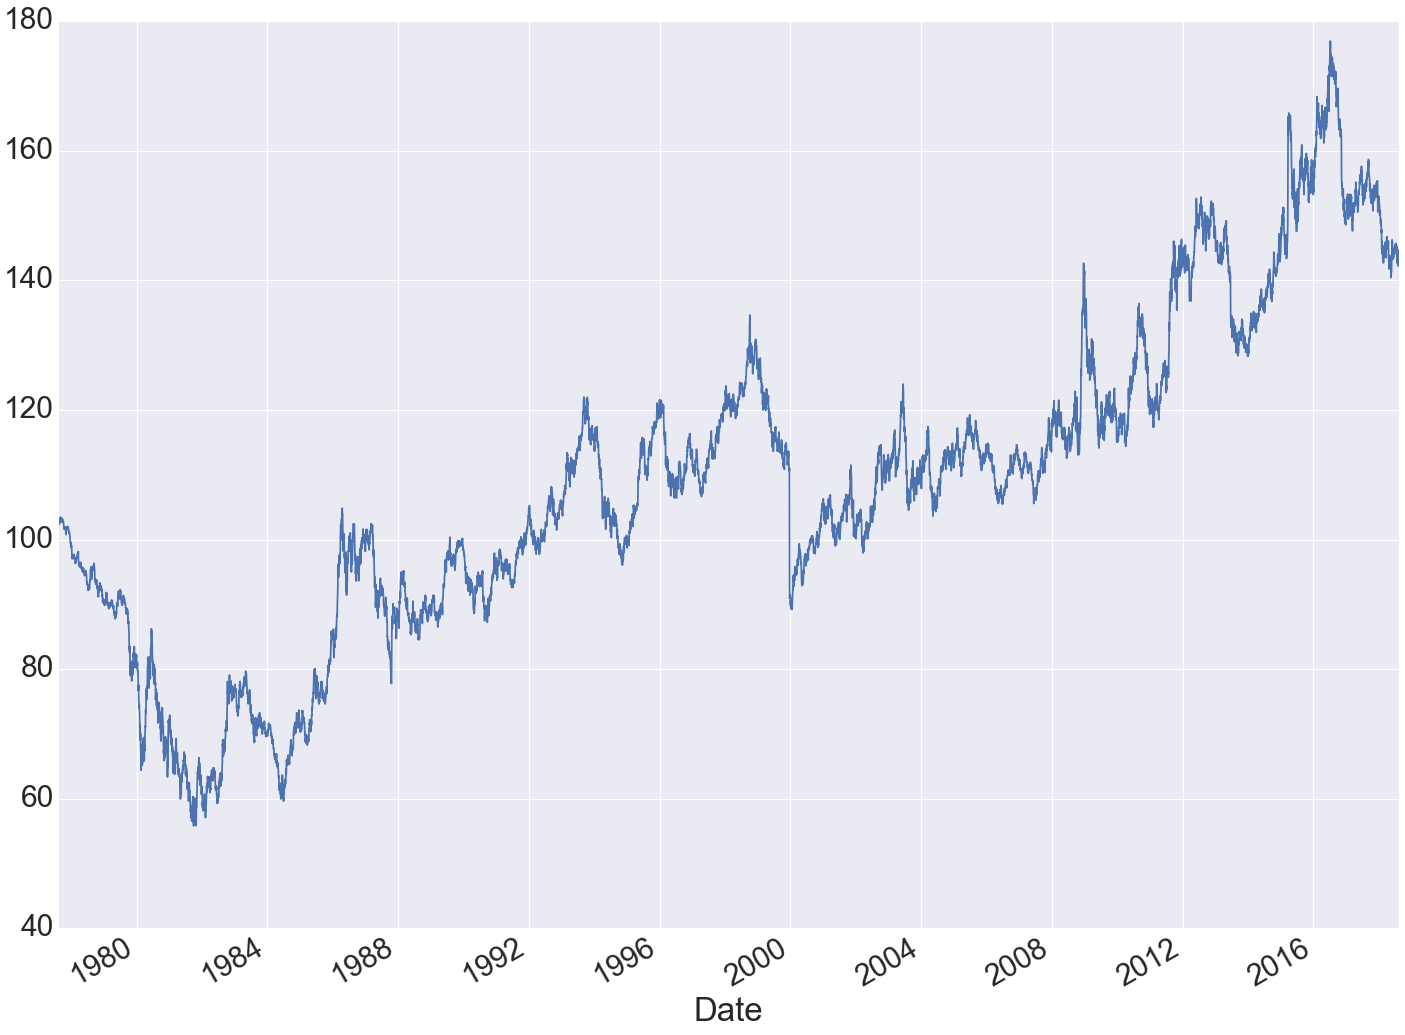

In [30]:
quandl.get("CHRIS/CME_US1", authtoken=token).Settle.plot()

In [40]:
df=pd.DataFrame()
df['SP500']=quandl.get("CHRIS/CME_SP1", authtoken=token).Settle
df['Copper']=quandl.get("CHRIS/CME_HG1", authtoken=token).Settle
df['Gold']=quandl.get("CHRIS/CME_GC1", authtoken=token).Settle
df['USD Index']=quandl.get("CHRIS/ICE_DX1", authtoken=token).Settle
df['US 10Y']=quandl.get("CHRIS/CME_US1", authtoken=token).Settle

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


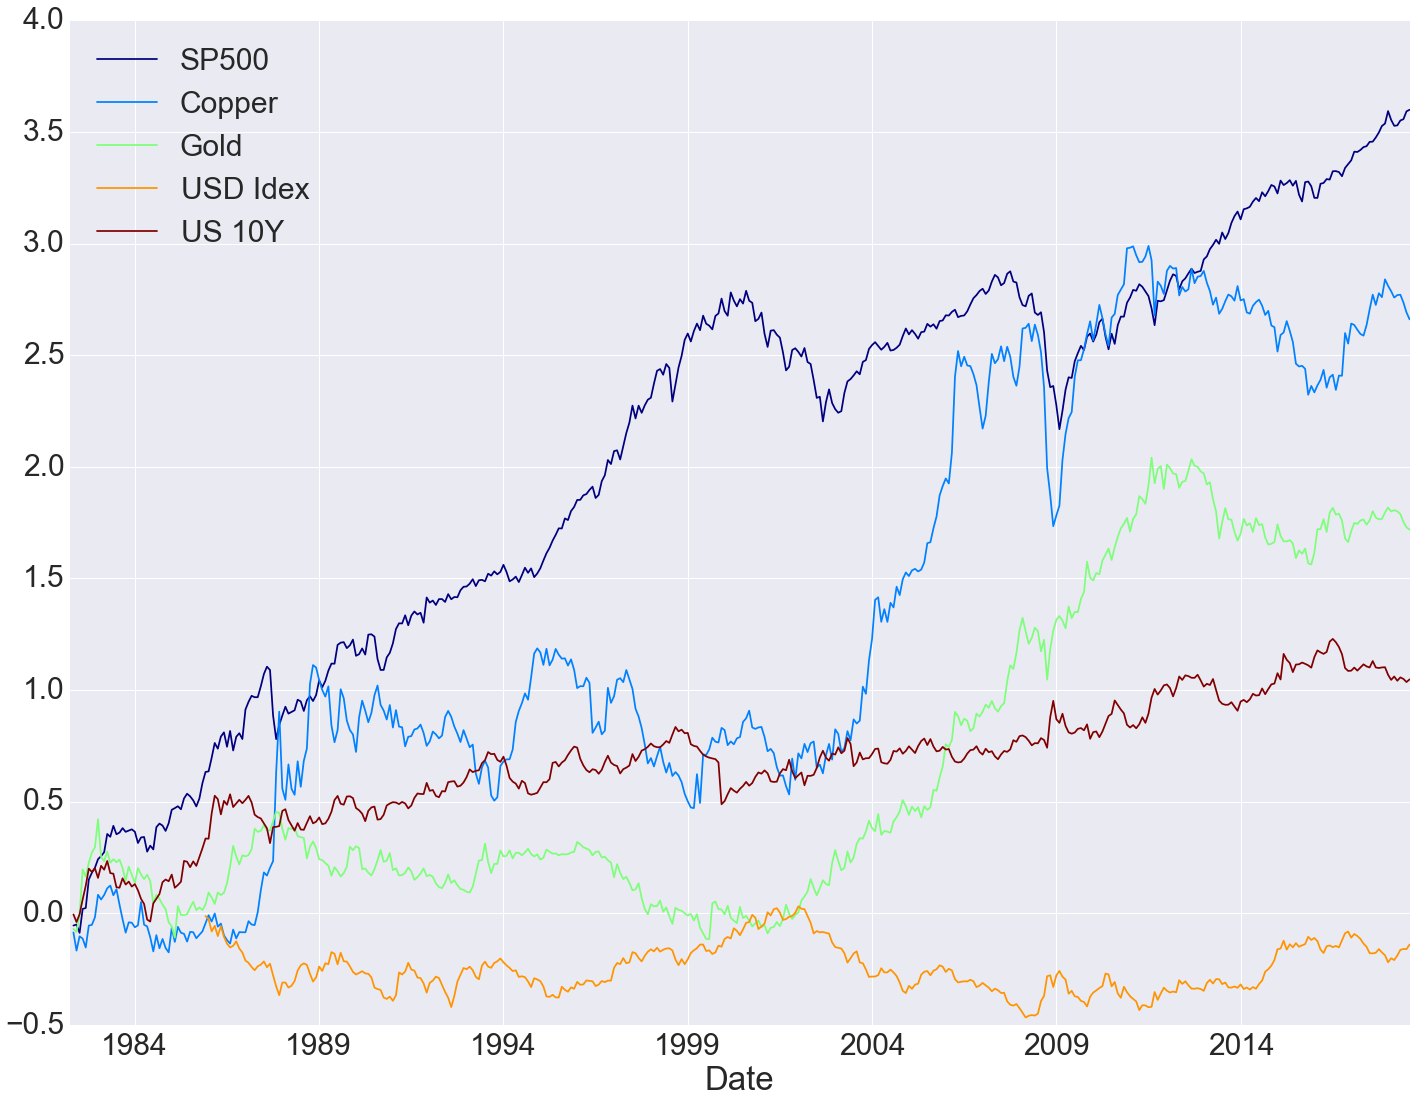

In [29]:
df.resample(rule='m',how='last').pct_change().cumsum().plot(colormap='jet')

In [41]:
price=df.resample(rule='m',how='last')
pct_rtns = price.pct_change()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


In [34]:
contract_mult=pd.Series({'SP500':50,
               'Copper': 2500,
               'Gold': 100,
               'USD Index': 1000,
               'US 10Y': 1000 })

# Signal

Moskowitz et al (2013): http://docs.lhpedersen.com/TimeSeriesMomentum.pdf

But we also need to scale each position.  As per the paper this is done by in volatility.

$$ signal = \frac{sign[r_{t-12,t}^s]}{\sigma_t^s} $$


In [42]:

vol_lookback=20
signal_lookback=12
vol=pd.ewmstd(pct_rtns,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
signal=pd.rolling_mean(pct_rtns,signal_lookback)
signal = signal /abs(signal)
position=(signal / vol)


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  """


In [53]:
position.shift()

,SP500,Copper,Gold,USD Index,US 10Y
Date,,,,,
2018-04-30,2.156975,1.078810,1.629525,-3.138774,-2.455701
2018-05-31,2.206723,1.105265,1.668002,-3.126151,-2.487967
2018-06-30,2.248728,1.132368,1.702679,-3.079374,-2.520268
2018-07-31,2.303486,1.144813,1.703043,-3.153217,-2.579606
2018-08-31,2.309074,-1.150635,-1.726120,3.230530,-2.627023


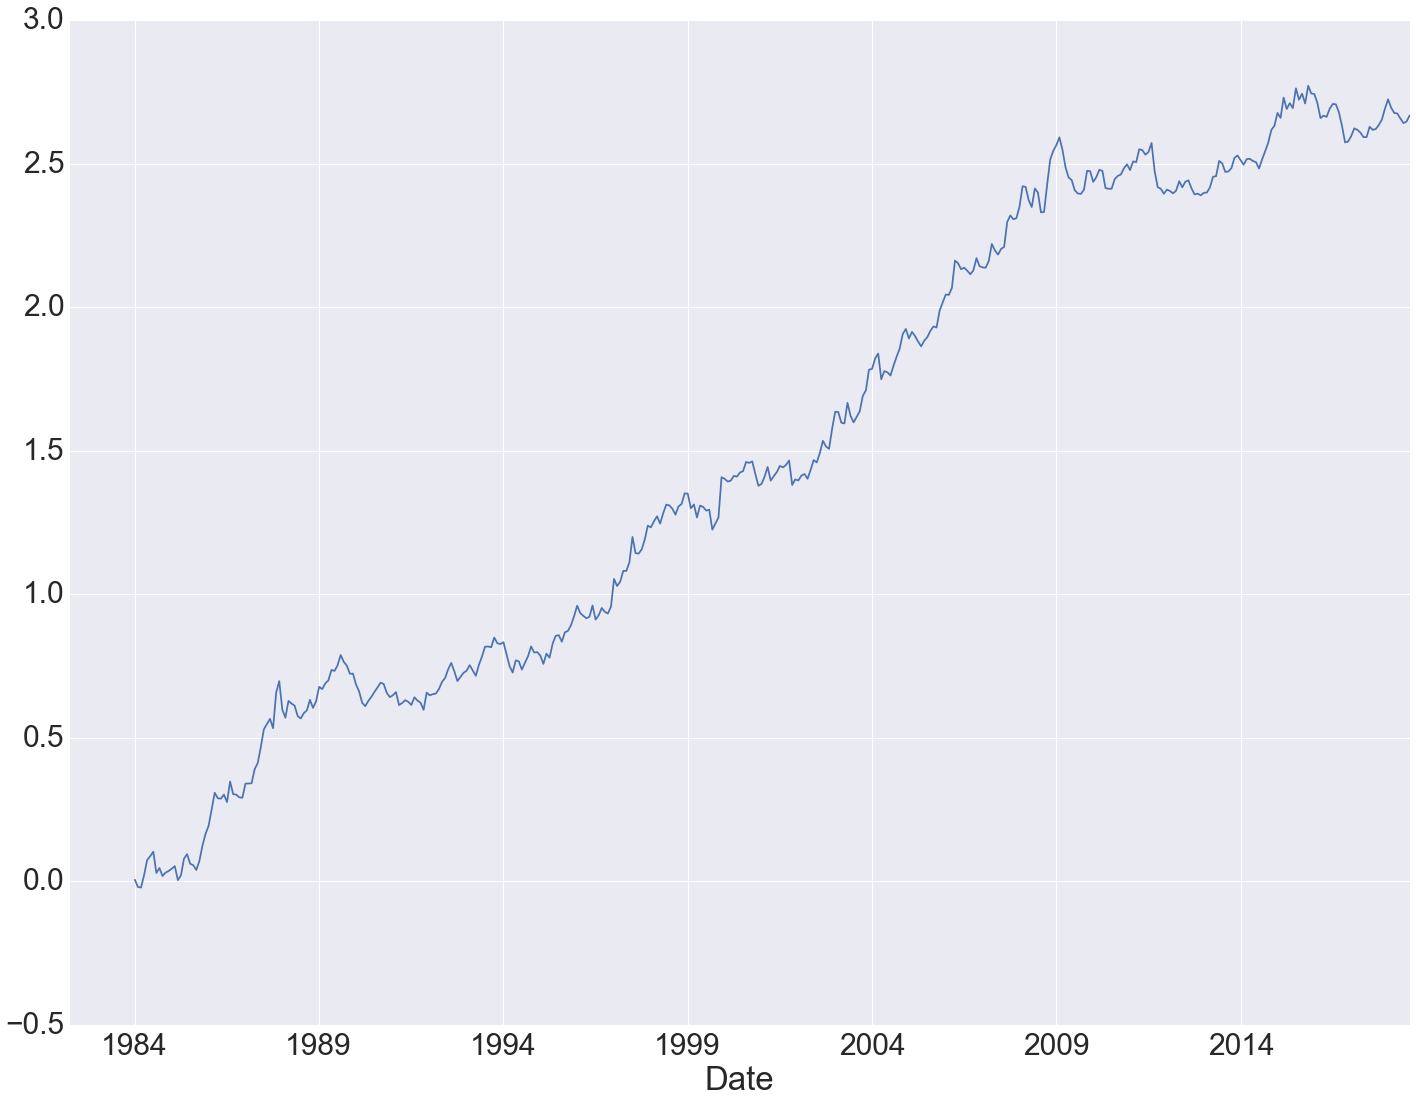

In [58]:
(position.shift()*pct_rtns).mean(axis=1).cumsum().plot()

# Scaling factor

Need to scale the portfolio to hit expected volatility.

$$ ScalingFactor = \frac{Target}{Expected[vol]}$$

Hard part, how do you estimate expected vol.  

$$ RealizedVol = w' \Sigma w $$

In [6]:
# Has a bit of hindsight bias involved since it uses entire time for Covariance matrixd
def calc_scaling_factor(pnl,vol_target=0.2):
    Sigma_all=pnl.cov().dropna(how='all',axis=1).dropna(how='all')
    ind=pnl.dropna(how='all').index
    SF=[]
    for row in pnl.dropna(how='all').iterrows():
        no_mkts=row[1].dropna().count()
        w=np.array([1/float(no_mkts)]*no_mkts)
        mkt_list=row[1].dropna().index
        Sig = Sigma_all[mkt_list].T[mkt_list]
        vol_ach=np.sqrt(np.dot(np.dot(w.T,Sig.as_matrix()),w))*16
        SF.append(vol_target/vol_ach)
    return pd.Series(SF,index=ind)

# Calculate Portfolio PNL 

$$ PNL_{Portfolio} = \sum_i^n \frac{1}{N}  PNL_i * ScalingFactor $$

In [ ]:
#remove_inf(pnl).mean(axis=1).dropna()*scaling_factor